In [1]:
import json
import os 
import argparse 
import torch 
import random 
import numpy as np
import pandas as pd 
from tqdm import tqdm 
from collections import defaultdict

from nnsight import LanguageModel
from datasets import load_dataset

/home/zy2559/.conda/envs/attendome/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def pile_chunk(random_len, pile, tok, shuf_pile=True):
    sample = []
    while len(sample) < random_len:
        doc = pile.shuffle()[0]['text'] # sample from huggingface
        sample = tok(doc, bos=False)[: random_len]
        if shuf_pile:
            random.shuffle(sample)
    return sample 

In [3]:
def get_l2_attn_weights(model, tokenized, layer, value_weighting):
    n_heads = model.config.num_attention_heads 
    head_dim = model.config.hidden_size // n_heads
    
    with torch.no_grad():
        with model.trace(tokenized):
            # positional_embeddings (cos, sin) each shape [bsz, seq_len, head_dim]
            position = model.model.layers[layer].self_attn.inputs[1]['position_embeddings']
            attention_mask = model.model.layers[layer].self_attn.inputs[1]['attention_mask']

            # [bsz, seq_len, model_size]
            query_states = model.model.layers[layer].self_attn.q_proj.output
            key_states = model.model.layers[layer].self_attn.k_proj.output 

            bsz = query_states.shape[0]; seq_len = query_states.shape[1] 
            if value_weighting:
                # [bsz, seq_len, model_size] -> [bsz, seq_len, n_heads, head_dim]
                value_states = model.model.layers[layer].self_attn.v_proj.output
                value_states = value_states.view(bsz, seq_len, n_heads, head_dim).save()

            # from modeling_llama, convert to [bsz, n_heads, seq_len, head_dim] and rotate 
            query_states = query_states.view(bsz, seq_len, -1, head_dim).transpose(1, 2)
            key_states = key_states.view(bsz, seq_len, -1, head_dim).transpose(1, 2)
            query_states, key_states = apply_rotary_pos_emb(query_states, key_states, position[0], position[1])

            # not needed because num_key_value_heads == num_attention_heads 
            # key_states = repeat_kv(key_states, self.num_key_value_groups)
            attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(head_dim)
            
            # has to be eager implementation 
            causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
            attn_weights = attn_weights + causal_mask
            attn_weights = attn_weights.save()
    
    if not value_weighting:
        return attn_weights.softmax(dim=-1).detach().cpu()
    else: 
        # get l2 norm of each head value vector [bsz, seq_len, n_heads] -> [bsz, n_heads, seq_len]
        value_norms = torch.linalg.vector_norm(value_states, dim=-1).detach().cpu().transpose(1, 2)

        # attn_weights [bsz, n_heads, seq_len, seq_len]
        attn_weights = attn_weights.softmax(dim=-1).detach().cpu()

        # then multiply by softmax values and normalize 
        effective = attn_weights * value_norms.unsqueeze(2).expand(attn_weights.shape)
        effective /= torch.sum(effective, dim=-1, keepdim=True)
        return effective 

In [4]:
def get_l3_attn_weights(model, tokenized, layer, value_weighting):
    n_heads = model.config.num_attention_heads 
    head_dim = model.config.hidden_size // n_heads
    
    with torch.no_grad():
        with model.trace(tokenized):
            # self.num_key_value_groups = config.num_attention_heads // config.num_key_value_heads
            n_kv_groups = model.model.layers[layer].self_attn.num_key_value_groups

            # positional_embeddings (cos, sin) each shape [bsz, seq_len, head_dim]
            position = model.model.layers[layer].self_attn.inputs[1]['position_embeddings']
            attention_mask = model.model.layers[layer].self_attn.inputs[1]['attention_mask']

            # grouped query means that we have more queries than we do keys/values
            query_states = model.model.layers[layer].self_attn.q_proj.output # [bsz, seq_len, model_size=4096]
            key_states = model.model.layers[layer].self_attn.k_proj.output  # [bsz, seq_len, 1024]
            bsz = query_states.shape[0]; seq_len = query_states.shape[1] 

            if value_weighting:
                value_states = model.model.layers[layer].self_attn.v_proj.output # [bsz, seq_len, 1024]
                value_states = value_states.view(bsz, seq_len, -1, head_dim).transpose(1, 2) # [bsz, seq_len, 8, head_dim] -> [bsz, 8, seq_len, head_dim]
                value_states = repeat_kv(value_states, n_kv_groups).save()

            # from modeling_llama, convert to [bsz, n_heads, seq_len, head_dim] and rotate 
            query_states = query_states.view(bsz, seq_len, -1, head_dim).transpose(1, 2)
            key_states = key_states.view(bsz, seq_len, -1, head_dim).transpose(1, 2)
            query_states, key_states = apply_rotary_pos_emb(query_states, key_states, position[0], position[1])

            # not needed because num_key_value_heads == num_attention_heads 
            key_states = repeat_kv(key_states, n_kv_groups)
            attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(head_dim)
            
            # has to be eager implementation 
            causal_mask = attention_mask[:, :, :, : key_states.shape[-2]]
            attn_weights = attn_weights + causal_mask
            attn_weights = attn_weights.save()
    
    if not value_weighting:
        return attn_weights.softmax(dim=-1).detach().cpu()
    else: 
        # get l2 norm of each head value vector [bsz, n_heads, seq_len]
        value_norms = torch.linalg.vector_norm(value_states, dim=-1).detach().cpu()

        # attn_weights [bsz, n_heads, seq_len, seq_len]
        attn_weights = attn_weights.softmax(dim=-1).detach().cpu()

        # then multiply by softmax values and normalize 
        effective = attn_weights * value_norms.unsqueeze(2).expand(attn_weights.shape)
        effective /= torch.sum(effective, dim=-1, keepdim=True)
        return effective

import torch 

# https://github.com/huggingface/transformers/blob/main/src/transformers/models/llama/modeling_llama.py#L178
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# can use for llama2, llama3, and olmo2 
def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    """Applies Rotary Position Embedding to the query and key tensors.

    Args:
        q (`torch.Tensor`): The query tensor.
        k (`torch.Tensor`): The key tensor.
        cos (`torch.Tensor`): The cosine part of the rotary embedding.
        sin (`torch.Tensor`): The sine part of the rotary embedding.
        position_ids (`torch.Tensor`, *optional*):
            Deprecated and unused.
        unsqueeze_dim (`int`, *optional*, defaults to 1):
            The 'unsqueeze_dim' argument specifies the dimension along which to unsqueeze cos[position_ids] and
            sin[position_ids] so that they can be properly broadcasted to the dimensions of q and k. For example, note
            that cos[position_ids] and sin[position_ids] have the shape [batch_size, seq_len, head_dim]. Then, if q and
            k have the shape [batch_size, heads, seq_len, head_dim], then setting unsqueeze_dim=1 makes
            cos[position_ids] and sin[position_ids] broadcastable to the shapes of q and k. Similarly, if q and k have
            the shape [batch_size, seq_len, heads, head_dim], then set unsqueeze_dim=2.
    Returns:
        `tuple(torch.Tensor)` comprising of the query and key tensors rotated using the Rotary Position Embedding.
    """
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed


def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    """
    This is the equivalent of torch.repeat_interleave(x, dim=1, repeats=n_rep). The hidden states go from (batch,
    num_key_value_heads, seqlen, head_dim) to (batch, num_attention_heads, seqlen, head_dim)
    """
    # print(hidden_states)
    # batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    batch = hidden_states.shape[0]
    num_key_value_heads = hidden_states.shape[1] 
    slen = hidden_states.shape[2]
    head_dim = hidden_states.shape[3]
    
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

In [5]:
import torch
import math

def get_qwen3_attn_weights(model, tokenized, layer, value_weighting=False):
    """
    Extract attention weights from a specific layer of a Qwen3 model.
    
    Args:
        model: Qwen3 model with tracing capability
        tokenized: Tokenized input
        layer: Layer index to extract attention from
        value_weighting: If True, weight attention by value vector magnitudes
    
    Returns:
        Attention weights tensor of shape [bsz, n_heads, seq_len, seq_len]
    """
    # Get model configuration
    config = model.config
    n_heads = config.num_attention_heads
    head_dim = config.hidden_size // n_heads
    
    # Qwen3 might use different config names, adjust as needed
    n_kv_heads = getattr(config, 'num_key_value_heads', n_heads)
    n_kv_groups = n_heads // n_kv_heads
    
    with torch.no_grad():
        with model.trace(tokenized):
            # Access the transformer layer - Qwen3 typically uses 'model.layers'
            layer_module = model.model.layers[layer]
            
            # Access self-attention module
            attn_module = layer_module.self_attn
            
            # Get query, key, value projections
            # Qwen3 typically uses q_proj, k_proj, v_proj naming
            query_states = attn_module.q_proj.output
            key_states = attn_module.k_proj.output
            
            if value_weighting:
                value_states = attn_module.v_proj.output
            
            # Get batch size and sequence length
            bsz, seq_len = query_states.shape[:2]
            
            # Reshape for multi-head attention
            # [bsz, seq_len, hidden_size] -> [bsz, seq_len, n_heads, head_dim] -> [bsz, n_heads, seq_len, head_dim]
            query_states = query_states.view(bsz, seq_len, n_heads, head_dim).transpose(1, 2)
            key_states = key_states.view(bsz, seq_len, n_kv_heads, head_dim).transpose(1, 2)
            
            if value_weighting:
                value_states = value_states.view(bsz, seq_len, n_kv_heads, head_dim).transpose(1, 2)
            
            # Apply rotary positional embeddings if used
            # Qwen3 typically uses RoPE, but the implementation might vary
            try:
                # Try to get position embeddings - this might need adjustment based on Qwen3's implementation
                if hasattr(attn_module, 'rotary_emb'):
                    cos, sin = attn_module.rotary_emb(value_states, seq_len=seq_len)
                    query_states, key_states = apply_qwen3_rotary_pos_emb(query_states, key_states, cos, sin)
                elif hasattr(layer_module, 'rotary_emb'):
                    cos, sin = layer_module.rotary_emb(value_states, seq_len=seq_len)
                    query_states, key_states = apply_qwen3_rotary_pos_emb(query_states, key_states, cos, sin)
            except:
                # If rotary embeddings fail, continue without them
                # This might happen if the model structure is different
                pass
            
            # Handle grouped query attention - repeat key/value states if needed
            if n_kv_groups > 1:
                key_states = repeat_kv(key_states, n_kv_groups)
                if value_weighting:
                    value_states = repeat_kv(value_states, n_kv_groups)
            
            # Compute attention scores
            attn_weights = torch.matmul(query_states, key_states.transpose(2, 3)) / math.sqrt(head_dim)
            
            # Apply causal mask
            # Create causal mask for autoregressive attention
            causal_mask = torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1)
            causal_mask = causal_mask.to(attn_weights.device)
            attn_weights = attn_weights.masked_fill(causal_mask, float('-inf'))
            
            # Save attention weights for extraction
            attn_weights = attn_weights.save()
            
            if value_weighting:
                value_states = value_states.save()
    
    # Apply softmax to get attention probabilities
    attn_probs = attn_weights.softmax(dim=-1).detach().cpu()
    
    if not value_weighting:
        return attn_probs
    else:
        # Compute value weighting
        value_states_cpu = value_states.detach().cpu()
        
        # Get L2 norm of each head value vector [bsz, n_heads, seq_len]
        value_norms = torch.linalg.vector_norm(value_states_cpu, dim=-1)
        
        # Weight attention by value magnitudes
        # attn_probs: [bsz, n_heads, seq_len, seq_len]
        # value_norms: [bsz, n_heads, seq_len]
        effective = attn_probs * value_norms.unsqueeze(2).expand(attn_probs.shape)
        
        # Renormalize
        effective = effective / (torch.sum(effective, dim=-1, keepdim=True) + 1e-8)
        
        return effective


def apply_qwen3_rotary_pos_emb(q, k, cos, sin, position_ids=None):
    """
    Apply rotary positional embeddings to query and key tensors.
    This is a simplified version - you might need to adjust based on Qwen3's exact implementation.
    
    Args:
        q: Query tensor [batch, n_heads, seq_len, head_dim]
        k: Key tensor [batch, n_heads, seq_len, head_dim]
        cos: Cosine values for rotary embedding
        sin: Sine values for rotary embedding
        position_ids: Position indices (optional)
    
    Returns:
        Rotated query and key tensors
    """
    # This is a simplified implementation
    # The actual Qwen3 implementation might be more complex
    
    def rotate_half(x):
        """Rotates half the hidden dims of the input."""
        x1 = x[..., : x.shape[-1] // 2]
        x2 = x[..., x.shape[-1] // 2 :]
        return torch.cat((-x2, x1), dim=-1)
    
    # Apply rotation
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    
    return q_embed, k_embed


# Example usage:
# attn_weights = get_qwen3_attn_weights(model, tokenized_input, layer=12, value_weighting=True)

In [6]:
torch.set_grad_enabled(False)

def generate_ragged_batch(batch_ents, pile, tok, seq_len):
    assert len({len(e) for e in batch_ents}) == 1

    newline = tok('\n', bos=False)[-1]
    bos = tok('', bos=True)[0]

    sequences = []
    start_idxs, end_idxs = [], []
    for ent in batch_ents:
        position = random.choice(range(seq_len // 2, seq_len - len(ent) + 1))
        rand1 = pile_chunk(position, pile, tok)
        rand2 = pile_chunk(seq_len - position - len(ent), pile, tok)

        start_idxs.append(position + 1)
        end_idxs.append(position + len(ent))
        sequences.append(
            [bos] + rand1 + ent + rand2 + [newline] + rand1 
        )

    # since batches have ragged ends by design, save padding offsets 
    flipped_masks = [m - 1 for m in tok(sequences, pad_mask=True)]
    pad_offsets = [-sum(f).item() for f in flipped_masks]

    return sequences, torch.tensor(start_idxs), torch.tensor(end_idxs), torch.tensor(pad_offsets)

def retrieve_attention(model, tokenized, layer, value_weighting=True):
    func = {
        'Qwen/Qwen3-4B' : get_qwen3_attn_weights,
        'meta-llama/Llama-3.2-3B-Instruct' : get_l3_attn_weights,
        'meta-llama/Llama-3.1-8B-Instruct' : get_l3_attn_weights,
        'meta-llama/Meta-Llama-3-8B' : get_l3_attn_weights,
        'meta-llama/Llama-2-7b-hf': get_l2_attn_weights
    }[model.config._name_or_path]

    return func(model, tokenized, layer, value_weighting)

def normalize(d, total):
    for k in d.keys():
        d[k] /= total 
    return d 

In [7]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', default='meta-llama/Llama-2-7b-hf')
parser.add_argument('--ckpt', default=None, type=str)
parser.add_argument('--n', default=2048, type=int)
parser.add_argument('--bsz', default=128, type=int, help='may have bugs with bsz=1.')
parser.add_argument('--sequence_len', default=30)
parser.add_argument('--random_tok_entities', action='store_true')
parser.set_defaults(random_tok_entities=False)
args = parser.parse_args("")

In [8]:
random.seed(8)
torch.manual_seed(8)
np.random.seed(8)

# args.model = 'meta-llama/Llama-3.2-3B-Instruct'
# args.model = 'meta-llama/Llama-3.1-8B-Instruct'
# args.model = 'meta-llama/Llama-2-7b-hf'
args.model = 'Qwen/Qwen3-4B'
model = LanguageModel(args.model, device_map='cuda')

In [9]:
model_name = args.model.split('/')[-1]
d = model.tokenizer.decode

assert args.bsz <= args.n // 4 

In [10]:
def tok(s, bos=False, model=model, pad_mask=False):
    if pad_mask:
        assert type(s) == list and type(s[0]) == list and type(s[0][0]) == int
        return model.tokenizer.pad({'input_ids' : s}, return_tensors='pt')['attention_mask']

    # otherwise get actual tokens 
    if 'llama' in model.config._name_or_path:
        if not bos: 
            return model.tokenizer(s)['input_ids'][1:]
        else:
            return model.tokenizer(s)['input_ids']
    elif 'qwen' in model.config._name_or_path.lower():
        # qwen models don't have a BOS token, so just return the tokens as-is
        return model.tokenizer(s)['input_ids']
    elif model.config._name_or_path in ['allenai/OLMo-2-1124-7B', 'EleutherAI/pythia-6.9b']:
        if not bos:
            return model.tokenizer(s)['input_ids']
        else:
            return [model.tokenizer.bos_token_id] + model.tokenizer(s)['input_ids']

# load in pile sample to use as basic material that we shuffle around 
# pile = load_dataset('NeelNanda/pile-10k')['train']
pile = load_dataset('JeanKaddour/minipile')['test']

In [15]:
model.tokenizer("hello! what's up?")['input_ids'], model.tokenizer("this is crazy")['input_ids']

([14990, 0, 1128, 594, 705, 30], [574, 374, 14264])

In [16]:
model.tokenizer.bos_token_id

In [11]:
# dummy entities for comparison 
sorted_entities = defaultdict(list)
if args.random_tok_entities:
    for i in range(args.n):
        doc_toks = []
        while len(doc_toks) < 5:
            doc = pile.shuffle()[0]['text']
            doc_toks = tok(doc)

        random.shuffle(doc_toks)
        if i % 4 == 0: 
            sorted_entities['bigram'].append(doc_toks[:2])
        elif i % 4 == 1: 
            sorted_entities['trigram'].append(doc_toks[:3])
        elif i % 4 == 2:
            sorted_entities['fourgram'].append(doc_toks[:4])
        elif i % 4 == 3: 
            sorted_entities['fivegram'].append(doc_toks[:5])
# load and sort entities of different token lengths
else:
    str_entities = list(pd.read_csv('./dataset_files/counterfact_expanded.csv')['subject'])
    for ent in str_entities:
        toks = tok(ent)
        if len(toks) == 2:
            sorted_entities['bigram'].append(toks)
        elif len(toks) == 3: 
            sorted_entities['trigram'].append(toks)
        elif len(toks) == 4: 
            sorted_entities['fourgram'].append(toks)
        elif len(toks) == 5: 
            sorted_entities['fivegram'].append(toks) 

TypeError: object of type 'NoneType' has no len()

In [12]:
# For each head, save the stuff 
total_examples = 0 
next_tok_attn = defaultdict(int)
end_tok_attn = defaultdict(int)

# I guess we're doing each batch is the same length entity 
for l, ents in sorted_entities.items():
    selected_ents = ents[ : args.n // 4]
    n_batches = len(selected_ents) // args.bsz
    print('attention for', l, model.tokenizer.decode(selected_ents[0]))

    for batch_idx in tqdm(range(n_batches)):
        batch_ents = selected_ents[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        batch_seqs, start_idxs, end_idxs, pad_offsets = generate_ragged_batch(batch_ents, pile, tok, args.sequence_len)

        print(repr(model.tokenizer.decode(batch_seqs[0])))
        print(start_idxs[0].item(), end_idxs[0].item(), model.tokenizer.decode(batch_seqs[0][start_idxs[0]]), model.tokenizer.decode(batch_seqs[0][end_idxs[0]]))

        # get attention patterns for each head and example 
        for layer in range(model.config.num_hidden_layers):
            # [bsz, n_heads, seq_from, seq_to]
            attns = retrieve_attention(model, batch_seqs, layer)

            # index in and save beginnings, ends 
            for head in range(model.config.num_attention_heads):
                next_tok_attn[(layer, head)] += attns[torch.arange(len(attns)), head, -1, start_idxs + pad_offsets].sum().item()
                end_tok_attn[(layer, head)] += attns[torch.arange(len(attns)), head, -1, end_idxs + pad_offsets].sum().item()
        
        total_examples += len(batch_ents)

attention for fivegram Danielle Darrieux


You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


'<s> anim save\n the = Create animation and objectvar  Step // Win1: result the Danielle Darrieux Change Ven’ue NASAs For\n anim save\n the = Create animation and objectvar  Step // Win1: result the'
19 23 Daniel ux



Fetching 2 files: 100%|██████████| 2/2 [08:38<00:00, 259.02s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

 25%|██▌       | 1/4 [13:39<40:57, 819.19s/it]

'<s>31 Minn25.119  \n6 (63 Germaine Greer FrameFrameurk XhardLB\n\n\n31 Minn25.119  \n6 (63'
17 21 Ger er


 50%|█████     | 2/4 [16:16<14:19, 429.56s/it]

'<s> to below for on find the details a to project the go you looking picture easy make click To pattern to are it Long-Term Capital Management interactions Exchange\n to below for on find the details a to project the go you looking picture easy make click To pattern to are it'
24 28 Long Management


 75%|███████▌  | 3/4 [18:54<05:05, 305.64s/it]

'<s> use\n Town project is Center Centeron MM\nequ aonequ Town lux mixed featuring Isabelle AutissierAccess Q\n:\n to\n use\n Town project is Center Centeron MM\nequ aonequ Town lux mixed featuring'
20 24 Isabel ier


100%|██████████| 4/4 [21:33<00:00, 323.31s/it]


attention for trigram Apple A5


  0%|          | 0/4 [00:00<?, ?it/s]

'<s>\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0. \xa0\xa0\xa0\xa0\nNO\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 Apple A5 Video\n\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0 \xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0. \xa0\xa0\xa0\xa0\nNO\xa0\xa0\xa0\xa0\xa0\xa0\xa0\xa0'
27 29 Apple 5


 25%|██▌       | 1/4 [02:49<08:28, 169.46s/it]

'<s> The\n K\nCharium\nie Spring Gpes -icken love ReI Jams\n Rollciates byitchen Sarah Waters\n: Q\n The\n K\nCharium\nie Spring Gpes -icken love ReI Jams\n Rollciates byitchen'
25 27 Sarah aters


 50%|█████     | 2/4 [05:38<05:38, 169.39s/it]

'<s> acrossined Canada researchers conference who of This assign together will haveday thousands bring- writing one exam from Sky Sports News the of ) Field1\n acrossined Canada researchers conference who of This assign together will haveday thousands bring- writing one exam from'
22 24 Sky News


 75%|███████▌  | 3/4 [08:27<02:49, 169.26s/it]

'<s>\nber if\n feet shook I off thoughtwithout you he stven less is the dust...raw no yourEries. Mount Fosterif N\n\nber if\n feet shook I off thoughtwithout you he stven less is the dust...raw no yourEries.'
26 28 Mount oster


100%|██████████| 4/4 [11:18<00:00, 169.64s/it]


attention for bigram Wellington


  0%|          | 0/4 [00:00<?, ?it/s]

'<s>ple topo help element matchet:books\n fatal error\n\n Q:\n throw NSArrayase failed. Wellingtonaking withLT B ME\nple topo help element matchet:books\n fatal error\n\n Q:\n throw NSArrayase failed.'
24 25 Well ington


 25%|██▌       | 1/4 [02:52<08:36, 172.12s/it]

'<s>leman Murwin’ Gentnings and Musical, Theder A Guide Best to- Love Award Tony, Areva\n options:\nBuild Q\nleman Murwin’ Gentnings and Musical, Theder A Guide Best to- Love Award Tony,'
23 24 Are va


 50%|█████     | 2/4 [05:44<05:44, 172.01s/it]

'<s>\npressed wasHow com an I NSString decom thatlib\nI with Q\n: NSString have z do ( an have\n Ipress table tennis Q\n\npressed wasHow com an I NSString decom thatlib\nI with Q\n: NSString have z do ( an have\n Ipress'
28 29 table tennis


 75%|███████▌  | 3/4 [08:38<02:52, 172.99s/it]

'<s>] Sub, X subject ImagedcMPMP- [jectX, - George Duke55-51\n1-0A0\n J\n] Sub, X subject ImagedcMPMP- [jectX, -'
16 17 George Duke


100%|██████████| 4/4 [11:31<00:00, 172.90s/it]


attention for fourgram Michel Denisot


  0%|          | 0/4 [00:00<?, ?it/s]

'<s>vDmanmanitiliashz (\n Dav ()\nashitavviliborn Modz Mod  Michel Denisot Fire badly dam\nvDmanmanitiliashz (\n Dav ()\nashitavviliborn Modz Mod '
24 27 Michel ot


 25%|██▌       | 1/4 [02:47<08:22, 167.36s/it]

'<s>{3\n\n Eation Reuclidean Ouriter Appro Ofvest Qment Inach Margit Sandemo:S QLT to\n\n flatX\n{3\n\n Eation Reuclidean Ouriter Appro Ofvest Qment Inach'
18 21 Mar demo


 50%|█████     | 2/4 [05:34<05:34, 167.09s/it]

'<s> caused Se and inous diseaselisvere central nerv by humans system Bay fatal HMAS Sydney, proved Carer herrie Through Fish lifeout time\n caused Se and inous diseaselisvere central nerv by humans system Bay fatal'
16 19 H Sydney


 75%|███████▌  | 3/4 [08:20<02:46, 166.71s/it]

'<s> India of to02 water,8 Uputed to poll 5 a surface1 is according’ %s0 Nam June Paik Rap Wisconsin\n India of to02 water,8 Uputed to poll 5 a surface1 is according’ %s0'
25 28 Nam ik


100%|██████████| 4/4 [11:09<00:00, 167.26s/it]


In [13]:
model_name

'Llama-2-7b-hf'

In [15]:
args.random_tok_entities

False

In [14]:
def json_tuple_keys(mapping):
    return [{'layer':k[0], 'head_idx': k[1], 'score' : v} for k, v in mapping.items()]

results = {
    'next_tok_attn' : json_tuple_keys(normalize(next_tok_attn, total_examples)),
    'end_tok_attn' : json_tuple_keys(normalize(end_tok_attn, total_examples))
}

path = f'./results/attention_scores/{model_name}/'
path += f'{args.ckpt}/' if args.ckpt is not None else ''
os.makedirs(path, exist_ok=True)

fname = f'n{args.n}_seqlen{args.sequence_len}'
fname += f'_randomtokents' if args.random_tok_entities else ''
fname += '.json'
print(path + fname)

with open(path + fname, 'w') as f:
    json.dump(results, f)

./results/attention_scores/Llama-2-7b-hf/n2048_seqlen30.json


In [18]:
for r in results['end_tok_attn']:
    if r['score'] > 0.18:
        print(f"layer: {r['layer']}, head: {r['head_idx']}, score: {r['score']}")

layer: 13, head: 23, score: 0.22054247744381428
layer: 14, head: 1, score: 0.3419952765107155
layer: 16, head: 17, score: 0.22978569567203522
layer: 16, head: 29, score: 0.1967000002041459
layer: 22, head: 17, score: 0.18392631318420172


In [41]:
for r in results['next_tok_attn']:
    if r['score'] > 0.7:
        print(f"layer: {r['layer']}, head: {r['head_idx']}, score: {r['score']}")

layer: 2, head: 16, score: 0.9304505363106728
layer: 2, head: 17, score: 0.8246364444494247
layer: 5, head: 8, score: 0.7392003536224365
layer: 14, head: 22, score: 0.9291573166847229


In [22]:
with open('./results/attention_scores/Llama-3.1-8B-Instruct/n2048_seqlen30_randomtokents.json', 'r') as file:
    attention_score = json.load(file)

In [23]:
all_induction_scores_new = []
for r in attention_score['next_tok_attn']:
    all_induction_scores_new.append(r['score'])

In [13]:
with open('./results/induction_heads/induction_dataset.json', 'r') as file:
    induction_scores = json.load(file)

In [18]:
induction_scores['model_results'][5]

{'model_name': 'meta-llama/Llama-3.1-8B-Instruct',
 'model_configuration': {'num_layers': 32,
  'num_heads': 32,
  'hidden_size': 4096},
 'induction_scores': [[0.002057015895843506,
   0.004554629325866699,
   9.041652083396912e-05,
   0.002595454454421997,
   0.0053444504737854,
   0.00609821081161499,
   0.005044519901275635,
   0.005181789398193359,
   0.008305668830871582,
   0.011712074279785156,
   0.00981128215789795,
   0.00990152359008789,
   0.009547591209411621,
   0.01265108585357666,
   0.01101827621459961,
   0.011073112487792969,
   0.006490349769592285,
   0.006488025188446045,
   0.006293296813964844,
   0.008196592330932617,
   0.00968468189239502,
   0.007330358028411865,
   0.008706450462341309,
   0.008365869522094727,
   0.00277063250541687,
   0.005135774612426758,
   0.0028919577598571777,
   0.005359292030334473,
   0.007312655448913574,
   0.005748748779296875,
   0.0039976537227630615,
   0.012755155563354492],
  [0.004854917526245117,
   0.008668601512908936

In [19]:
model_results = induction_scores['model_results'][5]

all_induction_scores_old = []
for layer_id in range(model_results['model_configuration']['num_layers']):
    for head_id in range(model_results['model_configuration']['num_heads']):
        score = model_results['induction_scores'][layer_id][head_id]
        all_induction_scores_old.append(score)
        if score > 0.5:
            print(layer_id, head_id, score)

2 22 0.8215408325195312
5 8 0.6422958374023438
5 11 0.579925537109375
8 1 0.8407974243164062
10 14 0.5748367309570312
15 1 0.684967041015625
15 30 0.9475479125976562
16 20 0.647491455078125
20 14 0.5614013671875


PearsonRResult(statistic=np.float64(0.9264447778716359), pvalue=np.float64(0.0))

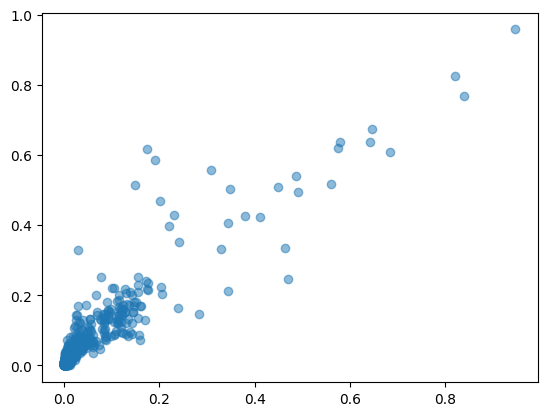

In [24]:
import matplotlib.pyplot as plt
plt.scatter(all_induction_scores_old, all_induction_scores_new, alpha=0.5)

from scipy.stats import pearsonr
pearsonr(all_induction_scores_old, all_induction_scores_new)